In [4]:
!nvidia-smi

Sun Oct 29 21:28:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.40       Driver Version: 516.40       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   54C    P3    18W /  N/A |      0MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [7]:
train_path = 'dataset/train/'
val_path = 'dataset/val/'

In [8]:
def sampleImg(num):
    plt.figure(figsize=(6, 6))
    fig, ax = plt.subplots(1, 2)
    img_high_res = cv2.imread(f'dataset/train/high_res/{num}.png')
    img_low_res = cv2.imread(f'dataset/train/low_res/{num}.png')
    ax[0].imshow(img_high_res)
    ax[1].imshow(img_low_res)
    ax[0].set_title(f'High Resolution Image\n{img_high_res.shape}')
    ax[1].set_title(f'Low Resolution Image\n{img_low_res.shape}')
    plt.tight_layout()
    plt.show()

<Figure size 600x600 with 0 Axes>

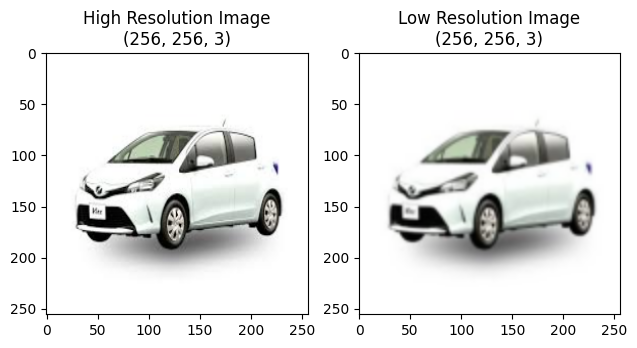

In [9]:
sampleImg(3)

In [10]:
def readImages(path):
    high_res_filenames = os.listdir(path+'/high_res/')
    low_res_filenames = os.listdir(path+'/low_res/')

    X = np.zeros((len(low_res_filenames), 256, 256, 3))
    y = np.zeros((len(high_res_filenames), 256, 256, 3))
    for i, filename in enumerate(high_res_filenames):
        y[i] = cv2.imread(path+'/high_res/'+filename)

    for i, filename in enumerate(low_res_filenames):
        X[i] = cv2.imread(path+'/low_res/'+filename)

    return X/255., y/255.

In [11]:
X_train, y_train = readImages('dataset/train')

In [12]:
X_train.shape, y_train.shape

((685, 256, 256, 3), (685, 256, 256, 3))

In [13]:
X_val, y_val = readImages('dataset/val/')

In [14]:
X_val.shape, y_val.shape

((170, 256, 256, 3), (170, 256, 256, 3))

In [33]:
def getModel(input_shape): 
    input_layer = Input(shape=input_shape, name='Input_Layer')
    conv1 = Conv2D(filters=32, kernel_size=3, padding='same', strides=2, name='Conv2D_1')(input_layer)
    batch1 = BatchNormalization(name='BatchNormalization_1')(conv1)
    leaky1 = LeakyReLU(0.3, name="LeakyReLU_1")(batch1)
    maxpool1 = MaxPool2D(pool_size=2, name='MaxPool_1')(leaky1)
    conv2 = Conv2D(filters=64, kernel_size=3, padding='same', strides=2, name='Conv2D_2')(maxpool1)
    batch2 = BatchNormalization(name="BatchNormalization_2")(conv2)
    leaky2 = LeakyReLU(0.3, name="LeakyReLU_2")(batch2)
    maxpool2 = MaxPool2D(pool_size=2, name='MaxPool_2')(leaky2)
    conv3 = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', kernel_regularizer='l1', name='Conv2D_3')(maxpool2)
    maxpool3 = MaxPool2D(pool_size=2, name='MaxPool_3')(conv3)
    conv4 = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', kernel_regularizer='l1', name='Conv2D_4')(maxpool3)
    maxpool4 = MaxPool2D(pool_size=2, name='MaxPool_4')(conv4)

    convt1 = Conv2DTranspose(filters=256, kernel_size=3, padding='same', activation='relu', name='Conv2DTranspose_1')(maxpool4)
    up1 = UpSampling2D(size=2, name='UpSampling2D_1')(convt1)
    convt2 = Conv2DTranspose(filters=128, kernel_size=3, padding='same', activation='relu', name='Conv2DTranspose_2')(up1)
    up2 = UpSampling2D(size=2, name='UpSampling2D_2')(convt2)
    convt3 = Conv2DTranspose(filters=32, kernel_size=3, padding='same', strides=2, activation='relu', name='Conv2DTranspose_3')(up2)
    up3 = UpSampling2D(size=2, name='UpSampling2D_3')(convt3)
    add1 = add([maxpool1, up3])
    convt4 = Conv2DTranspose(filters=32, kernel_size=3, padding='same', strides=2, activation='relu', name='Conv2DTranspose_4')(add1)
    add2 = add([conv1, convt4])
    convt5 = Conv2DTranspose(filters=3, kernel_size=3, padding='same', activation='relu', name='Conv2DTranspose_5')(add2)
    up4 = UpSampling2D(size=2, name="UpSampling2D_4")(convt5)


    model = Model(inputs=input_layer, outputs=up4, name='Model')
    return model

In [34]:
model = getModel(input_shape=(256, 256, 3))

In [35]:
model.summary()

Model: "Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_Layer (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Conv2D_1 (Conv2D)           (None, 128, 128, 32)         896       ['Input_Layer[0][0]']         
                                                                                                  
 BatchNormalization_1 (Batc  (None, 128, 128, 32)         128       ['Conv2D_1[0][0]']            
 hNormalization)                                                                                  
                                                                                                  
 LeakyReLU_1 (LeakyReLU)     (None, 128, 128, 32)         0         ['BatchNormalization_1[0][

In [36]:
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['acc'])

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [37]:
hist = model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_split=0.2)

Epoch 1/1000
5/5 [==============================] - 23s 3s/step - loss: 77.4965 - acc: 0.2350 - val_loss: 66.1873 - val_acc: 0.2455
Epoch 2/1000
5/5 [==============================] - 13s 3s/step - loss: 61.0300 - acc: 0.3888 - val_loss: 51.2311 - val_acc: 0.4153
Epoch 3/1000
5/5 [==============================] - 13s 3s/step - loss: 46.8523 - acc: 0.5412 - val_loss: 38.5423 - val_acc: 0.3604
Epoch 4/1000
5/5 [==============================] - 13s 2s/step - loss: 34.8570 - acc: 0.4633 - val_loss: 27.9336 - val_acc: 0.3607
Epoch 5/1000
5/5 [==============================] - 11s 2s/step - loss: 24.9118 - acc: 0.5655 - val_loss: 19.3376 - val_acc: 0.4547
Epoch 6/1000
5/5 [==============================] - 11s 2s/step - loss: 16.9964 - acc: 0.5774 - val_loss: 12.7931 - val_acc: 0.5162
Epoch 7/1000
5/5 [==============================] - 10s 2s/step - loss: 11.0960 - acc: 0.5925 - val_loss: 8.2164 - val_acc: 0.5331
Epoch 8/1000
5/5 [==============================] - 11s 2s/step - loss: 7.192

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [38]:
df = pd.DataFrame(hist.history)
df.head()

,loss,acc,val_loss,val_acc
0,77.496460,0.235037,66.187294,0.245509
1,61.030010,0.388813,51.231087,0.415266
2,46.852329,0.541155,38.542290,0.360380
3,34.856991,0.463346,27.933582,0.360744
4,24.911833,0.565542,19.337597,0.454651


In [39]:
df.to_csv("csvs/model_1000_epochs.csv", index=False)

In [40]:
model.evaluate(X_val, y_val, batch_size=32)

6/6 [==============================] - 1s 176ms/step - loss: 0.4800 - acc: 0.8338


[0.48004141449928284, 0.8337826132774353]

In [41]:
model.save("models/model_1000_epochs.h5")

a:\Sem 3\Neural Networks\Project\CSCI-5922-Deep-Learning-Project\venv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
preds = model.predict(X_val)
preds.shape

6/6 [==============================] - 1s 158ms/step


(170, 256, 256, 3)

<Figure size 600x600 with 0 Axes>

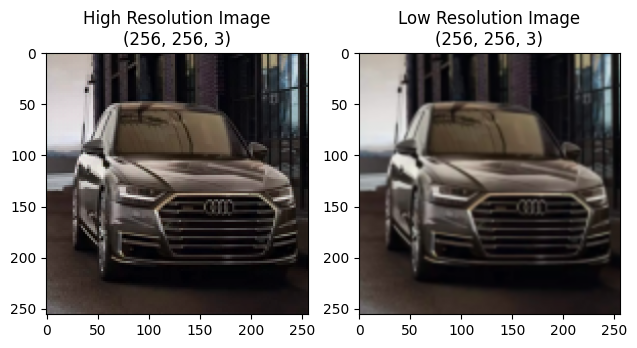

In [45]:
plt.figure(figsize=(6, 6))
fig, ax = plt.subplots(1, 2)
img_high_res = preds[123]
img_low_res = X_val[123]
ax[0].imshow(img_high_res)
ax[1].imshow(img_low_res)
ax[0].set_title(f'High Resolution Image\n{img_high_res.shape}')
ax[1].set_title(f'Low Resolution Image\n{img_low_res.shape}')
plt.tight_layout()
plt.show()